In [91]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def vectorize(item):
    doc = nlp(item)
    return doc.vector

In [16]:
def reduce_dims(train, n = 10):
    '''
    Take in a df and reduce the dimensions to 2.
    
    train -- (pd.DataFrame) - doc vector array for training set
    test -- (pd.DataFrame) - doc vector array for test set
    '''
    pca = PCA(n_components = n)
    transformed_X_train = pca.fit_transform(train)
    col_names = ["x"+ str(i) for i in range(0,n)]
    
    return pd.DataFrame(transformed_X_train, columns = col_names)

In [6]:
train_df = pd.read_csv("data/processed_train.csv")

In [5]:
nlp = spacy.load("en_core_web_md")

In [7]:
# create a df containing our document vectors
train_v = pd.DataFrame(np.vstack([vectorize(entry) for entry in train_df.text]))

In [27]:
# Reduce dimensions of train and test 
train_r = reduce_dims(train_v)

In [28]:
train_r # still might need to standardize the data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,-0.422301,-0.346069,-0.466255,0.088247,-0.543968,-0.133944,0.129977,0.531420,-0.183843,0.278415
1,0.887376,-0.228196,0.755970,0.037454,0.962083,-0.168307,0.558155,0.098573,-0.493225,0.110254
2,-0.278778,-0.898832,-0.523205,0.338114,0.102929,0.122487,0.133739,-0.382932,-0.057134,-0.151829
3,0.651418,-0.766114,-0.368506,0.306848,0.352546,0.330547,0.731837,-0.140192,0.069970,0.249347
4,0.100373,-0.093100,-0.067965,-0.471918,0.251957,0.580897,0.082390,0.068925,0.034867,0.316164
...,...,...,...,...,...,...,...,...,...,...
6965,0.305697,-0.168224,-0.312903,-0.039591,-0.041423,-0.009037,0.235551,0.318177,0.498311,0.297266
6966,-0.591139,-0.040124,0.171563,0.208324,0.390753,0.261343,-0.045000,0.013967,0.172710,-0.246762
6967,-0.233763,-0.874003,-0.142963,0.286627,0.116107,0.143994,0.025598,-0.095199,-0.020852,-0.134394
6968,-0.936364,-0.094487,0.046830,-0.222062,0.065609,0.087513,0.229242,-0.182576,0.086383,-0.046192


In [29]:
pca_df = pd.concat([train_df[['id']], train_r], axis = 1)

In [36]:
pca_df.drop(columns = 'id')

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,-0.422301,-0.346069,-0.466255,0.088247,-0.543968,-0.133944,0.129977,0.531420,-0.183843,0.278415
1,0.887376,-0.228196,0.755970,0.037454,0.962083,-0.168307,0.558155,0.098573,-0.493225,0.110254
2,-0.278778,-0.898832,-0.523205,0.338114,0.102929,0.122487,0.133739,-0.382932,-0.057134,-0.151829
3,0.651418,-0.766114,-0.368506,0.306848,0.352546,0.330547,0.731837,-0.140192,0.069970,0.249347
4,0.100373,-0.093100,-0.067965,-0.471918,0.251957,0.580897,0.082390,0.068925,0.034867,0.316164
...,...,...,...,...,...,...,...,...,...,...
6965,0.305697,-0.168224,-0.312903,-0.039591,-0.041423,-0.009037,0.235551,0.318177,0.498311,0.297266
6966,-0.591139,-0.040124,0.171563,0.208324,0.390753,0.261343,-0.045000,0.013967,0.172710,-0.246762
6967,-0.233763,-0.874003,-0.142963,0.286627,0.116107,0.143994,0.025598,-0.095199,-0.020852,-0.134394
6968,-0.936364,-0.094487,0.046830,-0.222062,0.065609,0.087513,0.229242,-0.182576,0.086383,-0.046192


In [31]:
# Want to see how the number of clusters changes with change in eps (also get cluster sizes)
# taken from cluster_tweets.ipynb
def cluster_text(df, eps, results, min_pt = 5):
    
    # Initiate DBSCAN using cosine distance for text
    dbscan = DBSCAN(metric = 'cosine', eps = eps, min_samples = min_pt)
    dbscan.fit(df.drop(columns= 'id'))
    
    # convert labels to a dataframe
    cluster_df = pd.DataFrame(dbscan.labels_, columns = ['cluster'])
    
    # isolate rows that don't belong to a cluster --> considered outliers
    outlier_cluster = cluster_df[cluster_df['cluster']== -1]

    # update dictionary to capture the number of outliers in each trial
    results['outlier_num'].append(len(outlier_cluster))
    
    # get the cluster counts
    cluster_counts = cluster_df.groupby('cluster').size()# gets counts for each cluster
    
    # cluster_counts.groupby('cluster').size()
    return cluster_counts

In [38]:
# Initate dictionary to capture results
result_dict = {'eps':[], 'cluster_amt':[], 'outlier_num': []}

# initiate eps space to crawl over
eps_space = list(np.linspace(0.01,1, num = 30))

# loop over each eps value
for value in eps_space:
    
    cluster_counts = cluster_text(pca_df, value, result_dict)
    result_dict['eps'].append(value)
    result_dict['cluster_amt'].append(len(cluster_counts))

In [40]:
results = pd.DataFrame(result_dict).head(10)
results['percent_outlier'] = results['outlier_num']/ len(pca_df) 

In [41]:
results

,eps,cluster_amt,outlier_num,percent_outlier
0,0.010000,10,6890,0.988522
1,0.044138,35,5371,0.770588
2,0.078276,25,2723,0.390674
3,0.112414,12,1085,0.155667
4,0.146552,4,374,0.053659
5,0.180690,3,88,0.012626
6,0.214828,2,22,0.003156
7,0.248966,2,3,0.000430
8,0.283103,1,0,0.000000
9,0.317241,1,0,0.000000


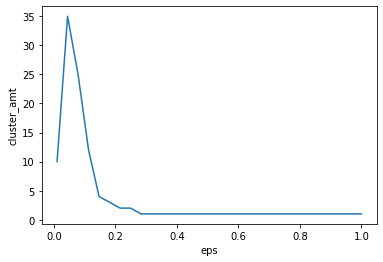

In [42]:
sns.lineplot(data = pd.DataFrame(result_dict), x = 'eps', y = 'cluster_amt')

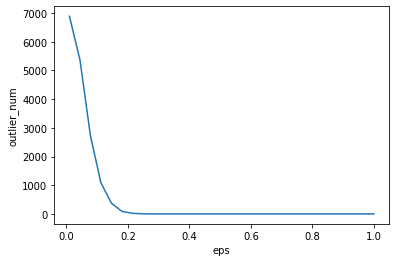

In [43]:
sns.lineplot(data = pd.DataFrame(result_dict), x = 'eps', y = 'outlier_num')

Compared to my previous clustering attempt without dimensionality reduction (cluster_tweets.ipynb), this result is much more reasonable. Note to self we can still change the number of components we reduce to. For now lets examine some of these eps values. 

In [47]:
def elaborate_dbscan(df, eps, min_pt = 5):
    
    # Initiate DBSCAN using cosine distance for text
    dbscan = DBSCAN(metric = 'cosine', eps = eps, min_samples = min_pt)
    dbscan.fit(df.drop(columns= 'id'))
    
    # convert labels to a dataframe
    cluster_df = pd.DataFrame(dbscan.labels_, columns = ['cluster'])
    
    # get the cluster counts
#     cluster_counts = cluster_df.groupby('cluster').size()# gets counts for each cluster
    
    # cluster_counts.groupby('cluster').size()
    return cluster_df

In [45]:
results['eps'][0]

0.01

In [67]:
cluster_df = elaborate_dbscan(pca_df, eps = results['eps'][1])

In [68]:
cluster_df.groupby('cluster').size()

cluster
-1     5371
 0        5
 1      942
 2      391
 3        5
 4        7
 5        6
 6        9
 7       40
 8       10
 9        8
 10       4
 11      20
 12       7
 13       6
 14      10
 15       6
 16      13
 17       6
 18       4
 19       5
 20       8
 21       5
 22       4
 23       5
 24       7
 25      16
 26       5
 27       6
 28       5
 29       5
 30      14
 31       5
 32       5
 33       5
dtype: int64

In this example, we are able to extract a cluster of almost 1000, something we weren't able to do before with the non-reduced dataset. Let's explore this more deeply.

In [72]:
merged_df = pd.concat([train_df, cluster_df], axis = 1)

In [73]:
merged_df.head()

,id,keyword,location,text,target,cluster
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,-1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,-1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,-1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,-1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,-1


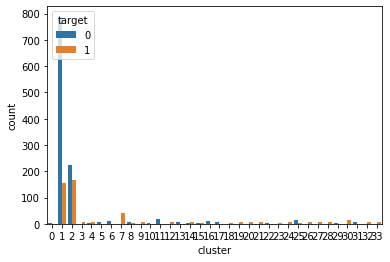

In [77]:
sns.countplot(data = merged_df[merged_df['cluster'] != -1], x = 'cluster', hue = 'target')

In [87]:
merged_df.groupby('cluster').agg(np.sum)

,id,target
cluster,,
-1,29152767,2379
0,25972,1
1,5069180,154
2,1969219,166
3,11519,5
4,29085,5
5,3101,1
6,6811,0
7,276253,40


In [81]:
#sns.countplot(data = merged_df[merged_df['cluster'] != -1], x = 'cluster', hue = 'keyword')

So still getting a lot of outliers but I am starting to resolve some clusters here. The next step is to do a large optimizing operation and see what I can obtain from it. Need to optimize:
- n_components
- min_pt
- eps

metrics:
- reduce number of outliers
- want to separate ideally into some more balanced clusters (although I need to think about this)


In [78]:
cluster_1 = merged_df[merged_df['cluster'] == 1]

In [111]:
list(cluster_1.sample(10).text)

["I get this feeling that society will collapse or implode. So don't be a hero and play your part.",
 "@Legna989 you're correct it is coming from both sides. Maybe I'm just friends on FB w more Rep so my feed is inundated w false claims...",
 'THE LINKS TO WATCH THE SHOW BETTER WORK OR I MIGHT ELECTROCUTE SOMEONE',
 "I'm not gonna lie I'm kinda ready to attack my Senior year ??????????",
 'MEN CRUSH EVERY FUCKING DAY????????????????????????????',
 'She screamed when she got the microchip needle. Tbh I would have cried too the needle was massive ya haram',
 'I sent my emails why are the TRINNA hold me hostage  rapping me up ??',
 'Good for her lol',
 "@eyecuts @Erasuterism I love 96 Gal Deco to death even if it's a bit trickier to be great with. Glad more weapons are getting Splash Wall",
 "If you're reading this go accidentally fall off a cliff mate"]

In [93]:
def document(item):
    doc = nlp(item)
    return doc

In [94]:
# convert text to doc
cluster_1['text'].apply(lambda x: document(x))

9       (I, 'm, afraid, that, the, tornado, is, coming...
25            (No, way, ..., I, ca, n't, eat, that, shit)
41      (on, the, outside, you, 're, ablaze, and, aliv...
43      (SOOOO, PUMPED, FOR, ABLAZE, ?, ?, ?, ?, @sout...
48      (First, night, with, retainers, in, ., It, 's,...
                              ...                        
6938    (@Caitsroberts, see, U, the, night, wee, bArra...
6943                    (He, just, wrecked, all, of, you)
6946    (Three, days, off, from, work, and, they, 've,...
6959    (I, just, heard, a, really, loud, bang, and, e...
6968    (on, the, flip, side, I, 'm, at, Walmart, and,...
Name: text, Length: 942, dtype: object

In [103]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [104]:
stop_words = set(stopwords.words('english')) 

In [107]:
# https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
wordcloud = WordCloud(stopwords = STOPWORDS).generate(' '.join(cluster_1['text']))

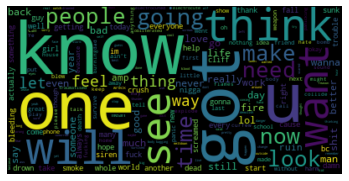

In [109]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Not sure WordCloud is the best way to assess the quality of the clusters...ie what themes are being extracted. Then again, I wonder if the dimensionality has been reduced too much in that we are just capturing more common words between the tweets